# Preprocessing wav files for ASR

In [1]:
import librosa, librosa.display
import numpy as np
from tensorflow.keras.utils import to_categorical
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd


2022-04-21 14:37:23.812792: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 14:37:23.812847: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In order to use deep learning for speech recognition, we need to convert our soundfiles to numerical respresentations.

Preprocessing procedure:

- convert audio to time series
- analyse fourier transform (*optional)
- for speech recognition use short-time fourier transform (stft)
- extract Mel-Frequency Cepstrum Cooefficients (feature extractions from stft)

## Converting wav files to Mel-Frequency Cepstral Coefficients (MFCCs)

### start with converting one wav file

In [2]:
DATA_PATH = "./raw_data/"

In [3]:
file_list_down = os.listdir(os.path.join(DATA_PATH, "down"))

In [4]:
# listen to first audio file in ./data/down
ipd.Audio(f'./raw_data/down/{file_list_down[0]}')

In [5]:
# use librosa.load to convert wave file to a time series
wave, sr = librosa.load(f'./raw_data/down/{file_list_down[0]}', mono=True, sr=None)
wave, sr

(array([0.00030518, 0.00210571, 0.00134277, ..., 0.00302124, 0.00393677,
        0.00274658], dtype=float32),
 16000)

Text(48.375, 0.5, 'Amplitude')

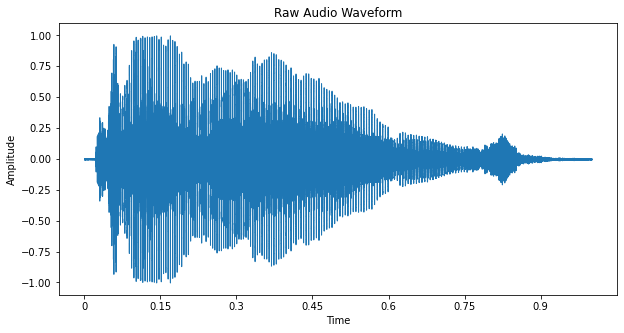

In [6]:
# use librosa.display.waveshot to plot the waveform
plt.figure(figsize=(10,5))
librosa.display.waveshow(wave, sr=sr)
plt.title("Raw Audio Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")

In [7]:
# transform wave from time domain to frequency domain
fft = np.fft.fft(wave)

Text(0, 0.5, 'Magnitude')

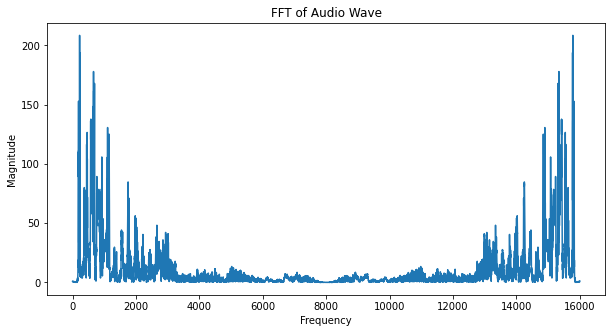

In [8]:
# visualize FFT
magnitude = np.abs(fft)
frequency = np.linspace(0,sr,len(magnitude))

plt.figure(figsize=(10,5))
plt.plot(frequency, magnitude)
plt.title("FFT of Audio Wave")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

Text(0, 0.5, 'Magnitude')

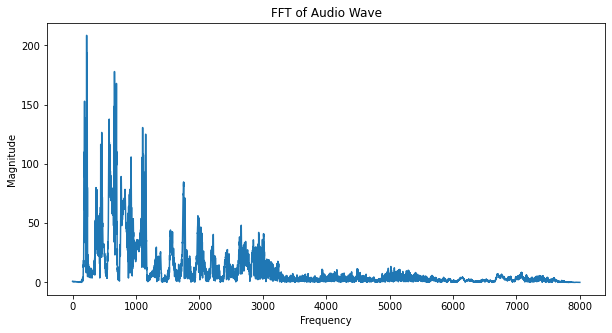

In [9]:
# notice the folding of the power at the nyquist frequency
# only need half of frequency range
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]

plt.figure(figsize=(10,5))
plt.plot(left_frequency, left_magnitude)
plt.title("FFT of Audio Wave")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

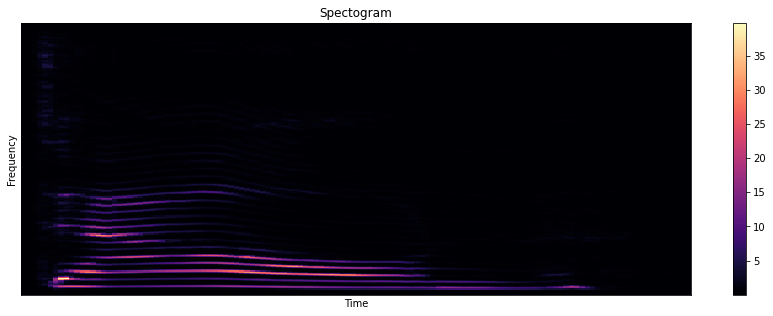

In [10]:
# short time fourier transform (stft) to spectogram
n_fft = 512 # length of the windowed signal after padding with zeros.

stft = librosa.core.stft(wave, n_fft=n_fft)

spectogram = np.abs(stft)

plt.figure(figsize=(15,5))
librosa.display.specshow(spectogram, sr=sr)
plt.title("Spectogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar();

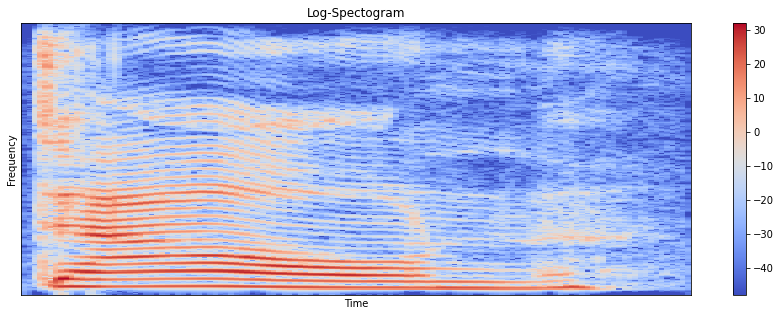

In [11]:
# apply log transform
log_spectogram = librosa.amplitude_to_db(spectogram)

plt.figure(figsize=(15,5))
librosa.display.specshow(log_spectogram, sr=sr)
plt.title("Log-Spectogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar();

/tmp/ipykernel_20894/3517977189.py:3: FutureWarning: Pass y=[0.00030518 0.00210571 0.00134277 ... 0.00302124 0.00393677 0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wave, sr=sr, n_mfcc=20)


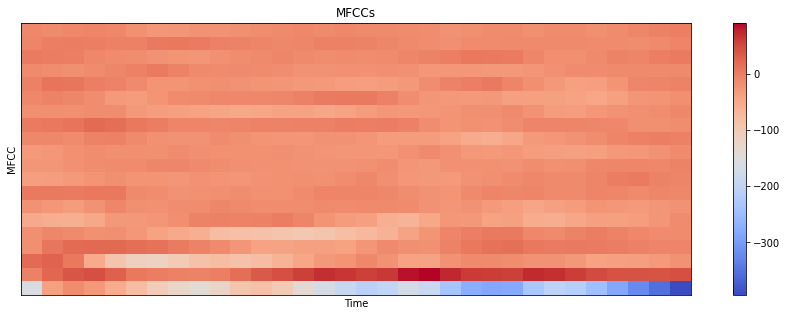

In [12]:
# extract mfcc
buckets = 20
mfccs = librosa.feature.mfcc(wave, sr=sr, n_mfcc=20)

plt.figure(figsize=(15,5))
librosa.display.specshow(mfccs, sr=sr)
plt.title("MFCCs")
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar();

In [13]:
# creating a function to automate the above steps
# note: that not all audio files will be the same length

def wav2mfcc(file_path, n_mfcc=20, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    #down sampling
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(y=wave, sr=16000, n_mfcc=n_mfcc)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc

### Converting all the wave files to MFCCs and add labels

#### Create labels for each wave file

In [14]:
# wave files are stored in subdircectors of the data folder
# the names of the subfolders are the labels
!cd ./data && ls

zsh:cd:1: no such file or directory: ./data


In [15]:
labels = os.listdir(DATA_PATH)
labels

['right', 'down', 'left', 'up']

In [16]:
# Create get_labels function
# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

#### Convert all waves

In [17]:
DATA_PATH = "./raw_data/"
max_len = 11
buckets = 20

lables, _, _ = get_labels(DATA_PATH)

for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [DATA_PATH + label + '/' + wavfile for wavfile in os.listdir(DATA_PATH + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len, n_mfcc=buckets)
            mfcc_vectors.append(mfcc)
        np.save('./processed_data/' + label + '.npy', mfcc_vectors)

Saving vectors of label - 'up': 100%|██████████████████████████████████████████████| 2375/2375 [00:10<00:00, 229.46it/s]


In [18]:
# Create save_data_to_array fucntion
# Input: Folder path, maximum length, number of mfccs to extract
# Output: numpy array file "*.npy" for each label
def save_data_to_array(path=DATA_PATH, max_len=11, n_mfcc=20):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len, n_mfcc=n_mfcc)
            mfcc_vectors.append(mfcc)
        np.save('./processed_data/' + label + '.npy', mfcc_vectors)